# Audio Preprocessing With Torchaudio

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from pathlib import Path

## Open File

Shape of waveform: torch.Size([1, 220568])
Sample rate of waveform: 22050


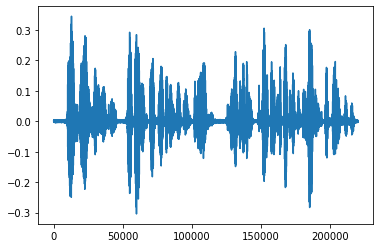

In [20]:
# Data from this website: https://www2.cs.uic.edu/~i101/SoundFiles/
filename = Path("../data/gettysburg10.wav")
waveform, sample_rate = torchaudio.load(filename)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.figure()
plt.plot(waveform.t().numpy())

## Transformations

Shape of spectrogram: torch.Size([1, 201, 1103])


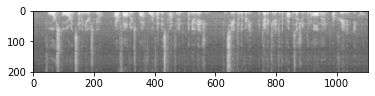

In [21]:
specgram = torchaudio.transforms.Spectrogram()(waveform)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')

Shape of spectrogram: torch.Size([1, 128, 1103])


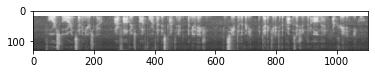

In [22]:
specgram = torchaudio.transforms.MelSpectrogram()(waveform)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
p = plt.imshow(specgram.log2()[0,:,:].detach().numpy(), cmap='gray')

Shape of transformed waveform: torch.Size([1, 22057])


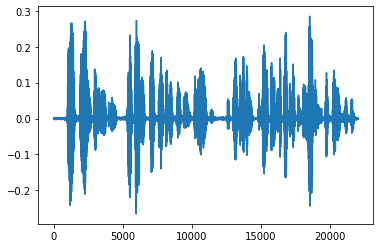

In [23]:
new_sample_rate = sample_rate/10

# Since Resample applies to a single channel, we resample first channel here
channel = 0
transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[channel,:].view(1,-1))

print("Shape of transformed waveform: {}".format(transformed.size()))

plt.figure()
plt.plot(transformed[0,:].numpy())

In [24]:
# Let's check if the tensor is in the interval [-1,1]
print("Min of waveform: {}\nMax of waveform: {}\nMean of waveform: {}".format(waveform.min(), waveform.max(), waveform.mean()))

Min of waveform: -0.30419921875
Max of waveform: 0.34521484375
Mean of waveform: -1.995912316488102e-05


In [ ]:
def normalize(tensor):
    # Subtract the mean, and scale to the interval [-1,1]
    tensor_minusmean = tensor - tensor.mean()
    return tensor_minusmean/tensor_minusmean.abs().max()

# Let's normalize to the full interval [-1,1]
# waveform = normalize(waveform)

Shape of transformed waveform: torch.Size([1, 220568])


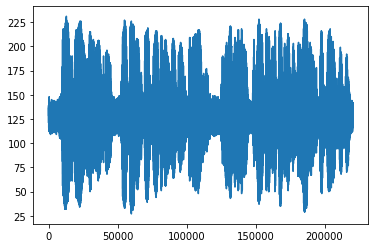

In [25]:
transformed = torchaudio.transforms.MuLawEncoding()(waveform)

print("Shape of transformed waveform: {}".format(transformed.size()))

plt.figure()
plt.plot(transformed[0,:].numpy())

Shape of recovered waveform: torch.Size([1, 220568])


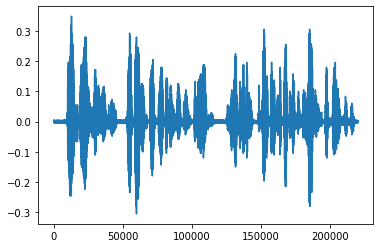

In [26]:
reconstructed = torchaudio.transforms.MuLawDecoding()(transformed)

print("Shape of recovered waveform: {}".format(reconstructed.size()))

plt.figure()
plt.plot(reconstructed[0,:].numpy())

In [27]:
# Compute median relative difference
err = ((waveform-reconstructed).abs() / waveform.abs()).median()

print("Median relative difference between original and MuLaw reconstucted signals: {:.2%}".format(err))

Median relative difference between original and MuLaw reconstucted signals: 1.89%


## Functional

Shape of transformed waveform: torch.Size([1, 220568])


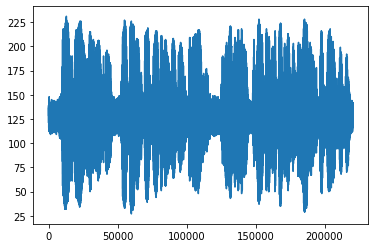

In [28]:
mu_law_encoding_waveform = torchaudio.functional.mu_law_encoding(waveform, quantization_channels=256)

print("Shape of transformed waveform: {}".format(mu_law_encoding_waveform.size()))

plt.figure()
plt.plot(mu_law_encoding_waveform[0,:].numpy())

Shape of computed deltas: torch.Size([1, 128, 1103])


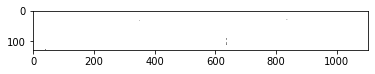

In [29]:
computed = torchaudio.functional.compute_deltas(specgram.contiguous(), win_length=3)
print("Shape of computed deltas: {}".format(computed.shape))

plt.figure()
plt.imshow(computed.log2()[0,:,:].detach().numpy(), cmap='gray')

In [30]:
gain_waveform = torchaudio.functional.gain(waveform, gain_db=5.0)
print("Min of gain_waveform: {}\nMax of gain_waveform: {}\nMean of gain_waveform: {}".format(gain_waveform.min(), gain_waveform.max(), gain_waveform.mean()))

dither_waveform = torchaudio.functional.dither(waveform)
print("Min of dither_waveform: {}\nMax of dither_waveform: {}\nMean of dither_waveform: {}".format(dither_waveform.min(), dither_waveform.max(), dither_waveform.mean()))

Min of gain_waveform: -0.5409511923789978
Max of gain_waveform: 0.6138884425163269
Mean of gain_waveform: -3.549273969838396e-05
Min of dither_waveform: -0.304168701171875
Max of dither_waveform: 0.345184326171875
Mean of dither_waveform: -4.957958026352571e-06


Min of lowpass_waveform: -0.30120956897735596
Max of lowpass_waveform: 0.3463159203529358
Mean of lowpass_waveform: -1.99722962861415e-05


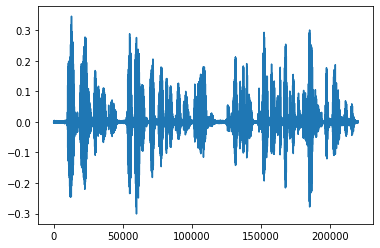

In [31]:
lowpass_waveform = torchaudio.functional.lowpass_biquad(waveform, sample_rate, cutoff_freq=3000)

print("Min of lowpass_waveform: {}\nMax of lowpass_waveform: {}\nMean of lowpass_waveform: {}".format(lowpass_waveform.min(), lowpass_waveform.max(), lowpass_waveform.mean()))

plt.figure()
plt.plot(lowpass_waveform.t().numpy())

Min of highpass_waveform: -0.09966200590133667
Max of highpass_waveform: 0.09959739446640015
Mean of highpass_waveform: 4.4171399871117956e-09


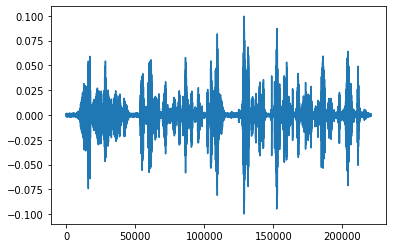

In [32]:
highpass_waveform = torchaudio.functional.highpass_biquad(waveform, sample_rate, cutoff_freq=2000)

print("Min of highpass_waveform: {}\nMax of highpass_waveform: {}\nMean of highpass_waveform: {}".format(highpass_waveform.min(), highpass_waveform.max(), highpass_waveform.mean()))

plt.figure()
plt.plot(highpass_waveform.t().numpy())

## Kaldi Compatibility

Shape of spectrogram: torch.Size([1101, 201])


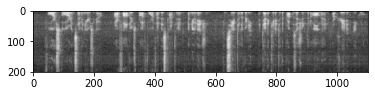

In [33]:
n_fft = 400.0
frame_length = n_fft / sample_rate * 1000.0
frame_shift = frame_length / 2.0

params = {
    "channel": 0,
    "dither": 0.0,
    "window_type": "hanning",
    "frame_length": frame_length,
    "frame_shift": frame_shift,
    "remove_dc_offset": False,
    "round_to_power_of_two": False,
    "sample_frequency": sample_rate,
}

specgram = torchaudio.compliance.kaldi.spectrogram(waveform, **params)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.t().numpy(), cmap='gray')

Shape of fbank: torch.Size([1101, 23])


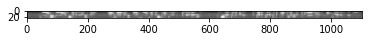

In [34]:
fbank = torchaudio.compliance.kaldi.fbank(waveform, **params)

print("Shape of fbank: {}".format(fbank.size()))

plt.figure()
plt.imshow(fbank.t().numpy(), cmap='gray')

Shape of mfcc: torch.Size([1101, 13])


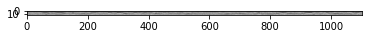

In [35]:
mfcc = torchaudio.compliance.kaldi.mfcc(waveform, **params)

print("Shape of mfcc: {}".format(mfcc.size()))

plt.figure()
plt.imshow(mfcc.t().numpy(), cmap='gray')

## Datasets

100.0%


Waveform: tensor([[-2.4414e-04, -3.0518e-04, -9.1553e-05,  ...,  3.6011e-03,
          4.9744e-03,  3.5095e-03]])
Sample rate: 8000
Labels: [1, 1, 0, 1, 1, 0, 0, 1]


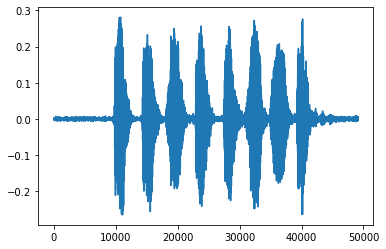

In [37]:
yesno_data = torchaudio.datasets.YESNO('../data/', download=True)

# A data point in Yesno is a tuple (waveform, sample_rate, labels) where labels is a list of integers with 1 for yes and 0 for no.

# Pick data point number 3 to see an example of the the yesno_data:
n = 3
waveform, sample_rate, labels = yesno_data[n]

print("Waveform: {}\nSample rate: {}\nLabels: {}".format(waveform, sample_rate, labels))

plt.figure()
plt.plot(waveform.t().numpy())